In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [3]:
date_today_record = str(date_today).split(' ')[0].replace('-', '')
date_today_record

'20210601'

In [4]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [5]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [6]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    if '건물명' in concat_df.columns:
        concat_df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
    elif '단지명' in concat_df.columns:
        concat_df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [7]:
target_house = '오피스텔'
house_df = data_prep(target_house, '매매')
house_df['부동산유형'] = target_house
print(house_df.shape)
house_df.head()

16it [00:00, 35.18it/s]


(180599, 12)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,6400,8,1997.0,9.0,2006-01-10,197.287300,24.0,오피스텔
1,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7100,7,1997.0,9.0,2006-01-10,218.865598,24.0,오피스텔
2,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7300,11,1997.0,9.0,2006-01-11,225.030826,24.0,오피스텔
3,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,31.91,7500,10,1997.0,9.0,2006-01-18,235.036039,24.0,오피스텔
4,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7400,15,1997.0,9.0,2006-01-19,228.113440,24.0,오피스텔


In [8]:
land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
print(land_specs_df.shape)
land_specs_df.head()

(8706295, 11)


,지번주소,년,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,공시지가
0,서울특별시 강남구 개포동 100-0,2013,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,325000.0
1,서울특별시 강남구 개포동 100-0,2014,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,330000.0
2,서울특별시 강남구 개포동 100-0,2015,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,335000.0
3,서울특별시 강남구 개포동 100-0,2016,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,345000.0
4,서울특별시 강남구 개포동 100-0,2017,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,355000.0


In [9]:
last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()

(981464, 9)


,지번주소,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면
0,서울특별시 강남구 개포동 100-0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지
1,서울특별시 강남구 개포동 101-0,전,641.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
2,서울특별시 강남구 개포동 102-0,전,509.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
3,서울특별시 강남구 개포동 103-0,전,48.7,자연녹지지역,개발제한구역,전,평지,부정형,맹지
4,서울특별시 강남구 개포동 104-1,전,2995.0,개발제한구역,자연녹지지역,전,완경사,부정형,맹지


In [10]:
house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)
print(house_merge_df.shape)

(178232, 20)


In [11]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [12]:
target_gu = '영등포구'
target_dong = '영등포동3가'
target_purpose = '일반상업'
target_building_age = 5
target_period = 18 # in months

In [13]:
target_df = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    &(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df.shape)
target_df.head()

(23, 22)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
170430,서울특별시 영등포구 영등포동3가 1-9,영등포로 264,소담더블린,15.64,13000,4,2018.0,2.0,2020-07-18,831.202046,3.0,오피스텔,대,163.6,일반상업지역,지정되지않음,상업용,평지,부정형,광대소각,영등포구,영등포동3가
176660,서울특별시 영등포구 영등포동3가 20-0,영중로4길 9,WD스퀘어,16.83,19000,8,2020.0,0.0,2020-12-15,1128.936423,1.0,오피스텔,대,928.0,일반상업지역,지정되지않음,업무용,평지,사다리형,소로각지,영등포구,영등포동3가
176661,서울특별시 영등포구 영등포동3가 20-0,영중로4길 9,WD스퀘어,16.72,19900,11,2020.0,1.0,2021-01-21,1190.191388,1.0,오피스텔,대,928.0,일반상업지역,지정되지않음,업무용,평지,사다리형,소로각지,영등포구,영등포동3가
176662,서울특별시 영등포구 영등포동3가 17-0,영등포로42길 9,다솔 메트로시티,25.74,34300,9,2020.0,0.0,2020-12-30,1332.556333,1.0,오피스텔,대,182.1,일반상업지역,지정되지않음,업무용,평지,사다리형,소로각지,영등포구,영등포동3가
176663,서울특별시 영등포구 영등포동3가 17-0,영등포로42길 9,다솔 메트로시티,27.73,35300,12,2020.0,1.0,2021-01-11,1272.989542,1.0,오피스텔,대,182.1,일반상업지역,지정되지않음,업무용,평지,사다리형,소로각지,영등포구,영등포동3가


In [14]:
sales_idx_basedir = './한국부동산원/실거래가격지수/'
filenames = [f for f in os.listdir(sales_idx_basedir) if '연립다세대' in f]

sales_idx_df = pd.read_excel(sales_idx_basedir + filenames[0], header=[10, 11])

sales_idx_cols_list = []
for i in range(sales_idx_df.shape[1]):
    if i == 0:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0])
    else:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0] + '_' + sales_idx_df.columns[i][1])

sales_idx_df.columns = sales_idx_cols_list

In [15]:
def get_sales_idx(x):
    # x is a pandas timestamp
    
    df = sales_idx_df.copy()
    
    if pd.isna(x) == True:
        return x
    else:
        year = str(x.year)
        month = str(x.month)
        if len(month) == 1:
            month = '0'+month
        
        idx = df[year+'년 '+month+'월_지수'].iloc[0]
        
        return idx

In [16]:
def get_index_applied_prices(df):
    df = df.copy()
    
    last_idx = sales_idx_df.iloc[0,-2]
    
    last_date = sales_idx_df.columns[-1].split('_')[0]
    
    last_date = last_date.split(' ')[0].replace('년','') + '-' + last_date.split(' ')[1].replace('월','') + '-01'
    
    target_upper_limit_df = df[df['계약날짜'] < pd.to_datetime(last_date)]
    target_upper_limit_df['계약날짜_실거래지수'] = target_upper_limit_df['계약날짜'].apply(get_sales_idx)
    target_upper_limit_df['지수적용단가'] = target_upper_limit_df['단가(만원/㎡)'] / target_upper_limit_df['계약날짜_실거래지수'] * last_idx
    df['지수적용단가'] = df['단가(만원/㎡)']
    df.loc[target_upper_limit_df.index, '지수적용단가'] = target_upper_limit_df['지수적용단가']
    df['평가날짜'] = df['계약날짜']
    df.loc[target_upper_limit_df.index, '평가날짜'] = pd.to_datetime(last_date[:-2] + '01')
    
    return df

In [17]:
target_df = get_index_applied_prices(target_df)
print(target_df.shape)
target_df.head()

(23, 24)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜
170430,서울특별시 영등포구 영등포동3가 1-9,영등포로 264,소담더블린,15.64,13000,4,2018.0,2.0,2020-07-18,831.202046,3.0,오피스텔,대,163.6,일반상업지역,지정되지않음,상업용,평지,부정형,광대소각,영등포구,영등포동3가,893.451253,2021-03-01
176660,서울특별시 영등포구 영등포동3가 20-0,영중로4길 9,WD스퀘어,16.83,19000,8,2020.0,0.0,2020-12-15,1128.936423,1.0,오피스텔,대,928.0,일반상업지역,지정되지않음,업무용,평지,사다리형,소로각지,영등포구,영등포동3가,1152.472385,2021-03-01
176661,서울특별시 영등포구 영등포동3가 20-0,영중로4길 9,WD스퀘어,16.72,19900,11,2020.0,1.0,2021-01-21,1190.191388,1.0,오피스텔,대,928.0,일반상업지역,지정되지않음,업무용,평지,사다리형,소로각지,영등포구,영등포동3가,1199.327226,2021-03-01
176662,서울특별시 영등포구 영등포동3가 17-0,영등포로42길 9,다솔 메트로시티,25.74,34300,9,2020.0,0.0,2020-12-30,1332.556333,1.0,오피스텔,대,182.1,일반상업지역,지정되지않음,업무용,평지,사다리형,소로각지,영등포구,영등포동3가,1360.337343,2021-03-01
176663,서울특별시 영등포구 영등포동3가 17-0,영등포로42길 9,다솔 메트로시티,27.73,35300,12,2020.0,1.0,2021-01-11,1272.989542,1.0,오피스텔,대,182.1,일반상업지역,지정되지않음,업무용,평지,사다리형,소로각지,영등포구,영등포동3가,1282.760934,2021-03-01


In [18]:
target_df = target_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df1 = target_df[['지번주소', '건물(단지)명', '건물연식', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1', '부동산유형']]
target_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [19]:
target_df1.head()

,지번주소,건물(단지)명,건물연식,전용면적(㎡),계약날짜,거래금액(만원),단가(만원/㎡),평가날짜,지수적용단가,용도지역명1,부동산유형
0,서울특별시 영등포구 영등포동3가 1-9,소담더블린,3.0,15.64,2020-07-18,13000,831.202046,2021-03-01,893.451253,일반상업지역,오피스텔
1,서울특별시 영등포구 영등포동3가 17-0,다솔 메트로시티,1.0,25.74,2020-12-30,34300,1332.556333,2021-03-01,1360.337343,일반상업지역,오피스텔
2,서울특별시 영등포구 영등포동3가 17-0,다솔 메트로시티,1.0,27.73,2021-01-11,35300,1272.989542,2021-03-01,1282.760934,일반상업지역,오피스텔
3,서울특별시 영등포구 영등포동3가 17-0,다솔 메트로시티,1.0,26.84,2021-01-24,35000,1304.023845,2021-03-01,1314.033454,일반상업지역,오피스텔
4,서울특별시 영등포구 영등포동3가 17-0,다솔 메트로시티,1.0,27.73,2021-01-25,34000,1226.108907,2021-03-01,1235.520446,일반상업지역,오피스텔


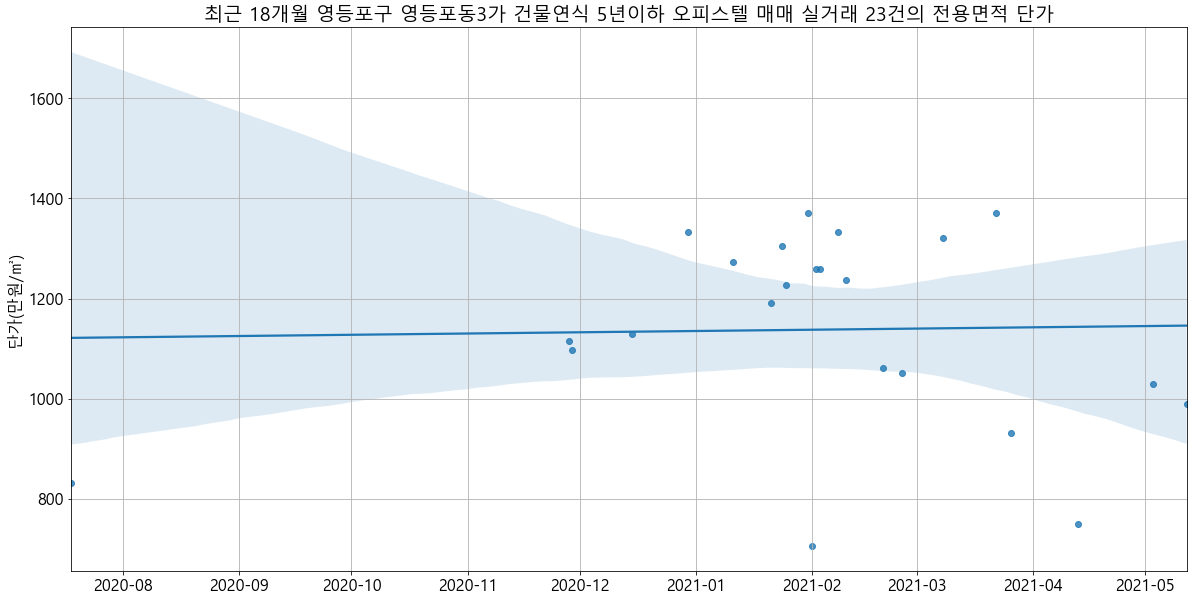

In [20]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/산포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [21]:
target_last_df = target_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last').reset_index(drop=True)

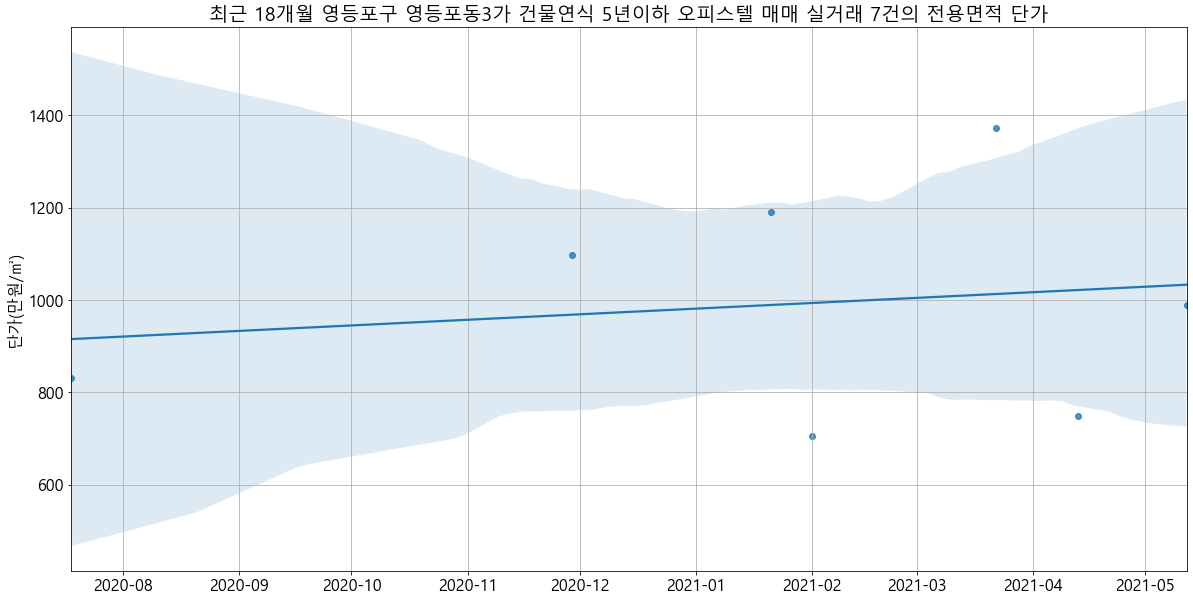

In [22]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_last_df['계약날짜']), y=target_last_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/마지막_산포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [23]:
target_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/마지막_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [24]:
target_df2 = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    #&(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['계약날짜기준_건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df2.shape)
target_df2.head()

(132, 22)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
104175,서울특별시 영등포구 영등포동3가 7-0,영중로 28,영등포 점프밀라노,37.05,13510,13,2005.0,1.0,2006-02-21,364.642375,16.0,오피스텔,대,113.1,일반상업지역,지정되지않음,상업용,평지,사다리형,광대소각,영등포구,영등포동3가
104176,서울특별시 영등포구 영등포동3가 7-0,영중로 28,영등포 점프밀라노,37.05,13510,13,2005.0,1.0,2006-02-21,364.642375,16.0,오피스텔,대,113.1,일반상업지역,지정되지않음,상업용,평지,사다리형,광대소각,영등포구,영등포동3가
104177,서울특별시 영등포구 영등포동3가 7-0,영중로 28,영등포 점프밀라노,57.44,18000,14,2005.0,3.0,2008-09-07,313.370474,16.0,오피스텔,대,113.1,일반상업지역,지정되지않음,상업용,평지,사다리형,광대소각,영등포구,영등포동3가
104178,서울특별시 영등포구 영등포동3가 7-0,영중로 28,영등포 점프밀라노,37.05,10500,15,2005.0,4.0,2009-03-25,283.400810,16.0,오피스텔,대,113.1,일반상업지역,지정되지않음,상업용,평지,사다리형,광대소각,영등포구,영등포동3가
104179,서울특별시 영등포구 영등포동3가 7-0,영중로 28,영등포 점프밀라노,33.21,10000,12,2005.0,4.0,2009-05-14,301.114122,16.0,오피스텔,대,113.1,일반상업지역,지정되지않음,상업용,평지,사다리형,광대소각,영등포구,영등포동3가


In [25]:
target_df2 = get_index_applied_prices(target_df2)

<AxesSubplot:title={'center':'영등포구 영등포동3가 계약날짜기준 건물연식 5년이하 오피스텔 매매 실거래 132건의 전용면적 단가'}, xlabel='단가(만원/㎡)', ylabel='Count'>

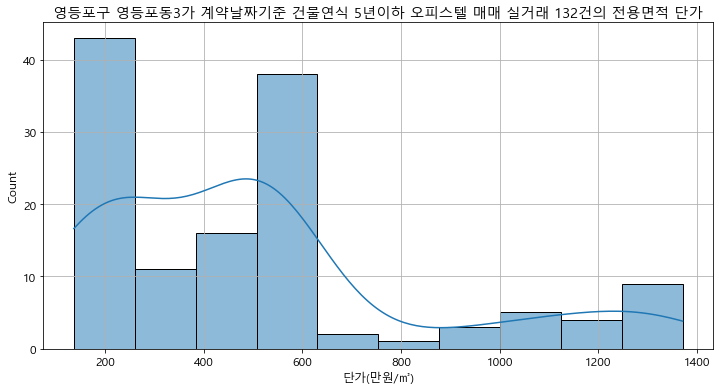

In [26]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_building_age, target_house, target_df2.shape[0]))
plt.grid(True)
sns.histplot(target_df2['단가(만원/㎡)'], kde=True)

In [27]:
target_df3 = target_df2[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1', '부동산유형']]
target_df3 = target_df3.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df3.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지수적용_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [28]:
concat_df = pd.concat([target_df2])

In [29]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
concat_df = concat_df.drop_duplicates(['지번주소', '건축년도', '전용면적(㎡)'], keep='last').reset_index(drop=True)

In [30]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']
concat_df['지수적용단가평균'] = concat_df[['지번주소', '건축년도', '지수적용단가']].groupby(['지번주소', '건축년도']).transform('mean')['지수적용단가']

In [31]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '평가날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(24, 26)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
0,서울특별시 영등포구 영등포동3가 1-9,영등포로 264,소담더블린,15.64,13000,4,2018.0,2.0,2020-07-18,831.202046,3.0,오피스텔,대,163.6,일반상업지역,지정되지않음,상업용,평지,부정형,광대소각,영등포구,영등포동3가,893.451253,2021-03-01,871.092229,1006.203011
1,서울특별시 영등포구 영등포동3가 1-9,영등포로 264,소담더블린,23.31,21235,5,2018.0,0.0,2018-04-10,910.982411,3.0,오피스텔,대,163.6,일반상업지역,지정되지않음,상업용,평지,부정형,광대소각,영등포구,영등포동3가,1118.954769,2021-03-01,871.092229,1006.203011
2,서울특별시 영등포구 영등포동3가 17-0,영등포로42길 9,다솔 메트로시티,26.84,33800,11,2020.0,1.0,2021-02-03,1259.314456,1.0,오피스텔,대,182.1,일반상업지역,지정되지않음,업무용,평지,사다리형,소로각지,영등포구,영등포동3가,1273.192653,2021-03-01,1289.216114,1298.386007
3,서울특별시 영등포구 영등포동3가 17-0,영등포로42길 9,다솔 메트로시티,27.73,34300,9,2020.0,1.0,2021-02-10,1236.927515,1.0,오피스텔,대,182.1,일반상업지역,지정되지않음,업무용,평지,사다리형,소로각지,영등포구,영등포동3가,1250.558998,2021-03-01,1289.216114,1298.386007
4,서울특별시 영등포구 영등포동3가 17-0,영등포로42길 9,다솔 메트로시티,25.74,35300,12,2020.0,1.0,2021-03-22,1371.406371,1.0,오피스텔,대,182.1,일반상업지역,지정되지않음,업무용,평지,사다리형,소로각지,영등포구,영등포동3가,1371.406371,2021-03-22,1289.216114,1298.386007


In [32]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df

(9, 26)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
1,서울특별시 영등포구 영등포동3가 1-9,영등포로 264,소담더블린,23.31,21235,5,2018.0,0.0,2018-04-10,910.982411,3.0,오피스텔,대,163.6,일반상업지역,지정되지않음,상업용,평지,부정형,광대소각,영등포구,영등포동3가,1118.954769,2021-03-01,871.092229,1006.203011
4,서울특별시 영등포구 영등포동3가 17-0,영등포로42길 9,다솔 메트로시티,25.74,35300,12,2020.0,1.0,2021-03-22,1371.406371,1.0,오피스텔,대,182.1,일반상업지역,지정되지않음,업무용,평지,사다리형,소로각지,영등포구,영등포동3가,1371.406371,2021-03-22,1289.216114,1298.386007
5,서울특별시 영등포구 영등포동3가 17-3,영중로8길 15,더-위일 신세계,17.66,19380,8,2020.0,0.0,2020-11-29,1097.395243,1.0,오피스텔,대,318.7,일반상업지역,지정되지않음,업무용,평지,부정형,세로각지(가),영등포구,영등포동3가,1129.664691,2021-03-01,1097.395243,1129.664691
7,서울특별시 영등포구 영등포동3가 20-0,영중로4길 9,WD스퀘어,16.83,19000,8,2020.0,0.0,2020-12-15,1128.936423,1.0,오피스텔,대,928.0,일반상업지역,지정되지않음,업무용,평지,사다리형,소로각지,영등포구,영등포동3가,1152.472385,2021-03-01,1159.563905,1175.899805
8,서울특별시 영등포구 영등포동3가 24-6,영중로8길 21,여의시티파크 A동,37.90,28400,3,2020.0,1.0,2021-04-13,749.340369,1.0,오피스텔,대,99.0,일반상업지역,지정되지않음,상업기타,평지,사다리형,세로각지(가),영등포구,영등포동3가,749.340369,2021-04-13,749.340369,749.340369
9,서울특별시 영등포구 영등포동3가 27-0,영중로8길 22,여의시티파크 B동,36.86,26000,2,2020.0,1.0,2021-02-01,705.371677,1.0,오피스텔,대,169.0,일반상업지역,지정되지않음,업무용,평지,부정형,세로각지(가),영등포구,영등포동3가,713.145181,2021-03-01,705.371677,713.145181
12,서울특별시 영등포구 영등포동3가 4-1,영등포로 234,여의도 포레스트 시티,29.93,29600,14,2021.0,0.0,2021-05-12,988.974273,0.0,오피스텔,대,66.1,일반상업지역,지정되지않음,업무용,평지,부정형,광대소각,영등포구,영등포동3가,988.974273,2021-05-12,982.847364,982.847364
15,서울특별시 영등포구 영등포동3가 7-0,영중로 28,영등포 점프밀라노,57.44,18000,14,2005.0,3.0,2008-09-07,313.370474,16.0,오피스텔,대,113.1,일반상업지역,지정되지않음,상업용,평지,사다리형,광대소각,영등포구,영등포동3가,414.370387,2021-03-01,345.080736,462.611536
23,서울특별시 영등포구 영등포동3가 9-13,영중로 12,에쉐르아이 시네마 쇼핑몰,30.21,14609,12,2005.0,5.0,2010-10-15,483.581595,16.0,오피스텔,대,2490.0,일반상업지역,지정되지않음,상업용,평지,부정형,광대세각,영등포구,영등포동3가,668.009222,2021-03-01,486.069141,669.487539


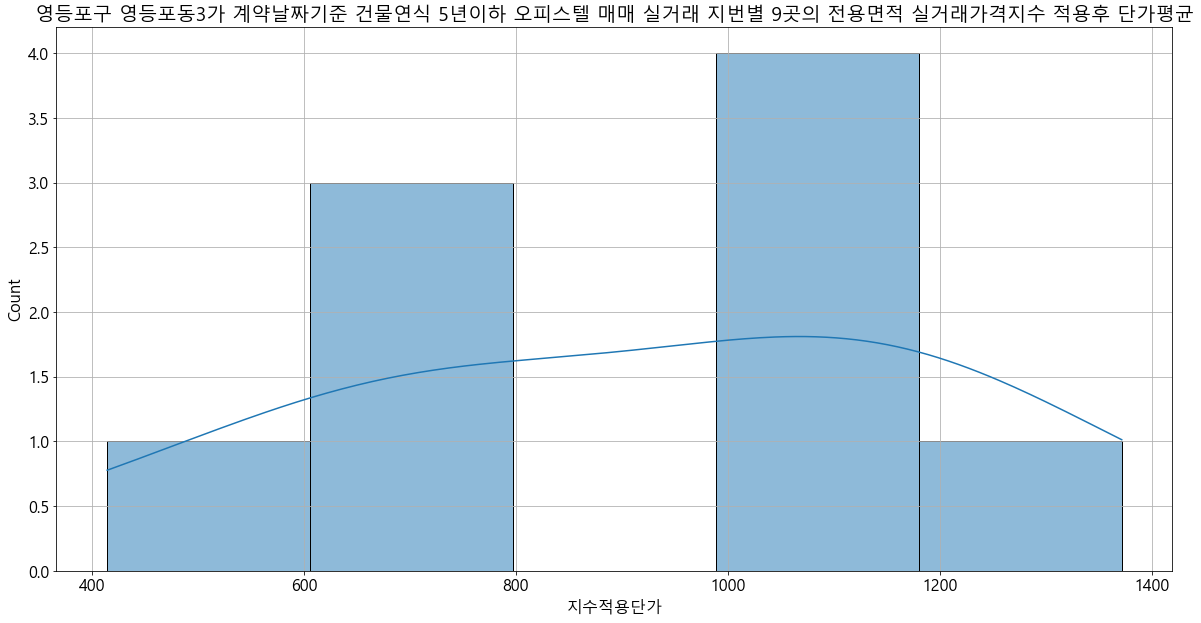

In [33]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 {} 매매 실거래 지번별 {}곳의 전용면적 실거래가격지수 적용후 단가평균'.format(target_gu, target_dong, target_building_age, target_house, concat_last_df.shape[0]))
plt.grid(True)
sns.histplot(concat_last_df['지수적용단가'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지번별_분포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [34]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [35]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1', '부동산유형']]
concat_last_df.rename(columns={'계약날짜':'마지막_계약날짜'}, inplace=True)
concat_last_df.head()

,지번주소,건물(단지)명,건축년도,전용면적(㎡),마지막_계약날짜,단가(만원/㎡),평가날짜,지수적용단가,용도지역명1,부동산유형
0,서울특별시 영등포구 영등포동3가 1-9,소담더블린,2018.0,23.31,2018-04-10,910.982411,2021-03-01,1118.954769,일반상업지역,오피스텔
1,서울특별시 영등포구 영등포동3가 17-0,다솔 메트로시티,2020.0,25.74,2021-03-22,1371.406371,2021-03-22,1371.406371,일반상업지역,오피스텔
2,서울특별시 영등포구 영등포동3가 17-3,더-위일 신세계,2020.0,17.66,2020-11-29,1097.395243,2021-03-01,1129.664691,일반상업지역,오피스텔
3,서울특별시 영등포구 영등포동3가 20-0,WD스퀘어,2020.0,16.83,2020-12-15,1128.936423,2021-03-01,1152.472385,일반상업지역,오피스텔
4,서울특별시 영등포구 영등포동3가 24-6,여의시티파크 A동,2020.0,37.90,2021-04-13,749.340369,2021-04-13,749.340369,일반상업지역,오피스텔


In [36]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지수적용_마지막_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)